## Exercise 1: Optimise lepton selection
In this first exercise the lepton selection will be optimised using Monte Carlo [MC] data

In [1]:
'''importing required libraries'''
from matplotlib import pyplot as plt
import numpy as np
import uproot
import awkward as ak
from scipy.optimize import curve_fit
import pandas as pd

In [2]:
'''defining functions to use later in the code. This cell does not need be understood right now and we advise to come back to it later'''

def plot_hist_of_arrays(list_of_arrays,
                        list_of_bins,
                        list_of_labels,
                        histtype='step',
                        xlabel='Enter X label!!',
                        ylabel='Counts',
                        xrange=None,
                        yrange=None,
                        title=None,
                        path_to_save_fig=False,
                        verbose=True
                        ):
    '''
    This function plots a histogram for a list of arrays
    :param list_of_arrays: input list of arrays to be plotted in a histogram
    :param list_of_bins: input list of bins to apply for the arrays for the histogram
    :param list_of_labels: input list of labels for the histograms
    :param histtype: step is the one we use here
    :param xlabel: string for label x axis of histogram
    :param ylabel: string for label y axis of histogram
    :param xrange: tuple for x range of histogram
    :param yrange: tuple for y range of histogram
    :param title: string for title of histogram
    :param path_to_save_fig: string for path to save histogram
    :param verbose:
    :return: bin content and bin edges for all input data
    '''
    counter = 0
    for array in list_of_arrays:
        if xrange:
            bin_content, bins_edges, _ = plt.hist(array, histtype=histtype, label=list_of_labels[counter],
                                                  bins=list_of_bins[counter], range=xrange)
        else:
            bin_content, bins_edges, _ = plt.hist(array, histtype=histtype, label=list_of_labels[counter],
                                                  bins=list_of_bins[counter])
        counter = counter + 1

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    if yrange:
        plt.ylim(yrange)
    if title:
        plt.title(title)
    if path_to_save_fig:
        plt.savefig(path_to_save_fig)
        if verbose:
            print(f'saving plot to {path_to_save_fig}')
    if verbose:
        plt.show()

    return bin_content, bins_edges


def get_efficiency_matrix(dic_data, cuts, variables):
    '''Calculates the acceptance matrix of the data arrays when applying cuts on the variables
    included in the dictionary. The errors of this matrix are determined via a Bayesian distribution
    and also returned.'''
    eff_matrix = np.zeros((4, 4))
    error_eff = np.zeros((4, 4))
    decay_modes = ['ee', 'mm', 'tt', 'qq']
    for (i, decay_filter) in zip(range(4), decay_modes):  # decay_filter is the decay mode which should be filtered
        for (j, decay_general) in zip(range(4), decay_modes):  # decay_general is the general decay mode filtered by the
            # cuts of deacy_filter
            mymask = True  # start with a general mask
            for var in variables:
                mymask *= dic_data[j][var] >= cuts[decay_filter][var][0]  # cut the lower bound
                mymask *= dic_data[j][var] <= cuts[decay_filter][var][
                    1]  # cut the upper bound and multiply boolean arrays
            number_passed_events = sum(mymask)
            total_number_events = len(mymask)
            eff_matrix[i][j] = number_passed_events / total_number_events  # efficiency
            variance = (number_passed_events + 1) * (number_passed_events + 2) / (total_number_events + 2) / (
                    total_number_events + 3) - (number_passed_events + 1) ** 2 / (total_number_events + 2) ** 2
            error_eff[i][j] = np.sqrt(variance)
    return eff_matrix, error_eff


def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2. * sigma ** 2))


def s_and_t_channel(cos_theta, A, B):
    return A * (1 + cos_theta ** 2) + B * (1 - cos_theta) ** (-2)


def s_channel(cos_theta, A):
    return A * (1 + cos_theta ** 2)


def t_channel(cos_theta, B):
    return B * (1 - cos_theta) ** (-2)

def integral_s_all(S):
    return 8 / 3 * S

def integral_tands_range(S, T):
    return 6443 / 3000 * S + 17 / 6 * T

def apply_cuts(dic_cuts, dic_data, cos_theta=True):
    '''Returns dictionary of data masks for all decay modes listed in dic_cuts'''
    decay_modes = dic_cuts.keys()
    if cos_theta:
        variables_with_cuts = ['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal', 'cos_thet']  # all variables that have cuts
    else:
        variables_with_cuts = ['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal']  # all variables that have cuts
    dic_masks = {}
    for mode in decay_modes:
        mask = True
        for var in variables_with_cuts:
            mask *= dic_data[var] >= dic_cuts[mode][var][0]
            mask *= dic_data[var] <= dic_cuts[mode][var][1]
        dic_masks[mode] = mask
    return dic_masks

def import_dictionary(path_to_dictionary, verbose=True):
    if verbose:
        print(f'importing dictionary from {path_to_dictionary}')
    return np.load(path_to_dictionary, allow_pickle=True).item()


def plot_cme_cross_sec(energy_data,
                       cross_section_data,
                       cross_section_data_error,
                       fit=True,
                       xlabel=r'COM energy $\sqrt{s}$ [GeV]',
                       ylabel=r'cross section $\sigma$ [nb]',
                       title=r'$e^{+}e^{-}$',
                       path_to_save_fig=None,
                       verbose=True):
    plt.errorbar(energy_data, cross_section_data, yerr=cross_section_data_error, fmt='x', capsize=1,
                 label='measured crosssection')
    if fit:
        coeffs, covariance = curve_fit(breit_wigner_distribution, energy_data, cross_section_data, p0=[91, 2.5, 5, 0],
                                       sigma=cross_section_data_error, absolute_sigma=False)
#                                        sigma=cross_section_data_error, absolute_sigma=True)
        x_array = np.linspace(energy_data[0] - 0.3, energy_data[-1] + 0.3, 1000)
        plt.errorbar(x_array, breit_wigner_distribution(x_array, *coeffs), fmt='-',
                     label='Breit Wigner fit')
        errors_st_fit = np.sqrt(np.diag(covariance))  # determine the (uncorrelated) uncertainties of the fit parameters
        if verbose:
            print(f'info for plot: {title}')
            print(f'fit parameters: {coeffs}')
            print(f'errors of fit: {errors_st_fit}')
        chi_sqrd_fit = np.sum(
            (cross_section_data - breit_wigner_distribution(energy_data, *coeffs)) ** 2
            / np.sqrt(cross_section_data_error) ** 2) / len(
            cross_section_data)  # Calculate chi squared/dof for the fit
        if verbose:
            print(f'chi squared test: {chi_sqrd_fit}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    if path_to_save_fig:
        plt.savefig(path_to_save_fig)
        if verbose:
            print(f'saving plot to {path_to_save_fig}')
    if verbose:
        plt.show()

    return coeffs, errors_st_fit


def t_test(valueA, valueB, u_valueA, u_valueB):
    """Returns the compatibility of two values with uncertainties."""
    return abs(valueA - valueB) / (np.sqrt(u_valueA ** 2 + u_valueB ** 2))

def breit_wigner_distribution(energy, m_z, gamma_z, amplitude, sigma0):
    ''' insert natural units for this equation!!'''
    return amplitude * (energy ** 2 / ((energy ** 2 - m_z ** 2) ** 2 + (gamma_z ** 2) * (m_z ** 2))) + sigma0

def get_gamma_ee(amplitude, m_z):
    return np.sqrt((amplitude * m_z ** 2) / (12 * np.pi))


def get_gamma_ee_error(gamma_ee, a, error_a, m_z, error_m_z):
    return gamma_ee * np.sqrt((error_a/(2 * a))**2 + (error_m_z/m_z)**2)


def get_gamma_ff(amplitude, m_z, gamma_ee):
    return (amplitude * m_z ** 2) / (12 * np.pi * gamma_ee)


def get_gamma_ff_error(gamma_ff, a, error_a, m_z, error_m_z, gamma_ee, error_gamma_ee):
    return gamma_ff * np.sqrt((error_a/a)**2 + (2* error_m_z/m_z)**2 + (error_gamma_ee/gamma_ee)**2)


First the data from the MC simulation need to be opened. This is done by using uproot. Uproot is a reader and a writer of the ROOT file format using only Python and Numpy. Unlike PyROOT and root_numpy, uproot does not depend on C++ ROOT so that no local compilation of the ROOT libraries is needed to access the data.

The data is next converted into dictionarys for better accessibility later in the code.
In this first Part of the code only the variables Pcharged, Ncharged, E_ecal, and E_hcal will be investigated. All MC data account for the beam Energy $E_\mathrm{lep} = 45.6\  $GeV.

In [3]:
path_to_base_dir = 'Data/'

'''read MC files using uproot'''
ee_data = uproot.open(path_to_base_dir + 'ee.root')
mm_data = uproot.open(path_to_base_dir + 'mm.root')
tt_data = uproot.open(path_to_base_dir + 'tt.root')
qq_data = uproot.open(path_to_base_dir + 'qq.root')

'''name the ttree name'''
ttree_name = 'myTTree'

'''Load branches into arrays'''
branches_ee = ee_data[ttree_name].arrays()
branches_mm = mm_data[ttree_name].arrays()
branches_tt = tt_data[ttree_name].arrays()
branches_qq = qq_data[ttree_name].arrays()

'''create a list to go through different variables'''
variables = ['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal']

''' The list of branches in th TTree (i.e. list of variable names) may be printed with the below command'''
# print(ee_data[ttree_name].keys())

' The list of branches in th TTree (i.e. list of variable names) may be printed with the below command'

In [4]:
'''labels for the decay types for legends'''
decay_types_labels = [r'$e^{+}e^{-}$', r'$\mu^{+}\mu^{-}$', r'$\tau^{+}\tau^{-}$', r'$q\bar{q}$'] 

'''create dictionaries for each decay product'''
ee_dic = {}
mm_dic = {}
tt_dic = {}
qq_dic = {}

'''fill dictionaries'''
for var in variables:
    ee_dic[var] = ak.to_numpy(branches_ee[var])
    mm_dic[var] = ak.to_numpy(branches_mm[var])
    tt_dic[var] = ak.to_numpy(branches_tt[var])
    qq_dic[var] = ak.to_numpy(branches_qq[var])

'''combine all dictionarys into one large dictionary'''
all_dic = [ee_dic, mm_dic, tt_dic, qq_dic]

'''Create arrays for each variable which has the data for all 4 decay types'''
Pcharged = []
Ncharged = []
E_ecal = []
E_hcal = []

'''add data using the dictionary into the above created arrays'''
for dic in all_dic:
    Pcharged.append(dic[variables[0]])
    Ncharged.append(dic[variables[1]])
    E_ecal.append(dic[variables[2]])
    E_hcal.append(dic[variables[3]])

Next the histograms for all four investigated variables are plotted. Through looking at the graphs and the preliminary insights from the grope analysis the initial guess for the cuts are defined. Further info on the plotting method may be found in the documentation of the function at the beginning of this document.

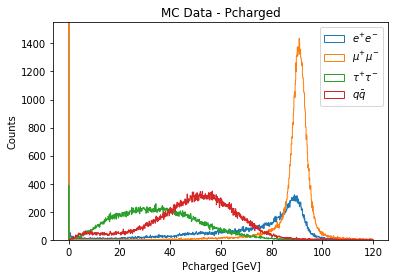

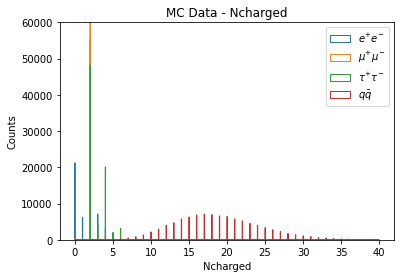

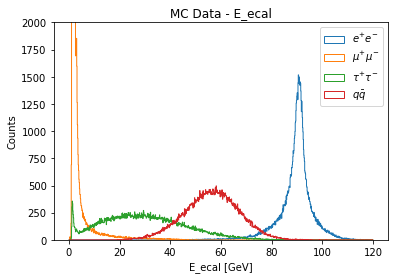

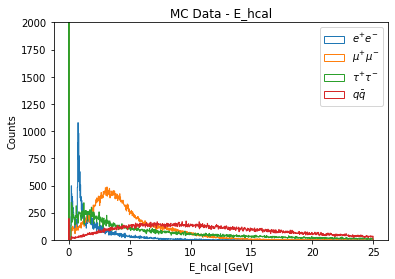

In [5]:
plot_hist_of_arrays(list_of_arrays=Pcharged,
                    list_of_labels=decay_types_labels,
                    list_of_bins=[1000, 1000, 1000, 1000],
                    title='MC Data - Pcharged',
                    xrange=(0, 120),
                    yrange=(0, 1550),
                    xlabel='Pcharged [GeV]'
                    )
plot_hist_of_arrays(list_of_arrays=Ncharged,
                    list_of_labels=decay_types_labels,
                    list_of_bins=[1000, 1000, 1000, 1000],
                    title='MC Data - Ncharged',
                    xrange=(0, 40),
                    yrange=(0, 60000),
                    xlabel='Ncharged'
                    )
plot_hist_of_arrays(list_of_arrays=E_ecal,
                    list_of_labels=decay_types_labels,
                    list_of_bins=[1000, 1000, 1000, 1000],
                    title='MC Data - E_ecal',
                    xrange=(0, 120),
                    yrange=(0, 2000),
                    xlabel='E_ecal [GeV]'
                    )
plot_hist_of_arrays(list_of_arrays=E_hcal,
                    list_of_labels=decay_types_labels,
                    list_of_bins=[1000, 1000, 1000, 1000],
                    title='MC Data - E_hcal',
                    xrange=(0, 25),
                    yrange=(0, 2000),
                    xlabel='E_hcal [GeV]'
                    )

'''create dictionary for cuts definition'''
cuts_initial = {'ee': {}, 'mm': {}, 'tt': {}, 'qq': {}}

'''first guess cuts manually defined by looking at the graphs'''
cuts_initial['ee'] = {'Ncharged': (0, 6),
                      'Pcharged': (0, 120),
                      'E_ecal': (70, 120),
                      'E_hcal': (0, 10)}
cuts_initial['mm'] = {'Ncharged': (0, 6),
                      'Pcharged': (0, 120),
                      'E_ecal': (0, 15),
                      'E_hcal': (0, 10)}
cuts_initial['tt'] = {'Ncharged': (0, 6),
                      'Pcharged': (0, 60),
                      'E_ecal': (0, 60),
                      'E_hcal': (0, 120)}
cuts_initial['qq'] = {'Ncharged': (6, 60),
                      'Pcharged': (0, 120),
                      'E_ecal': (40, 80),
                      'E_hcal': (0, 120)}

The data points in the above shown histograms are obtained from counting the number of events. Therefore, for large numbers of counts it can be described by a Poisson distribution. Thus the error for each data point $N$ is calculated via $\sqrt{N}$. For clarity purposes errorbars are not included in our histograms.

To be able to quantify and optimise the selection of the cuts an efficiency matrix is computed. The efficiency matrix $\epsilon_{ij}$ quantifies how many events of type $j$ pass the filters of type $i$. This can also later be applied in the analysis to correct for the event selection. Further information on the efficiency matrix may be seen at the documentation of the function at the top of this document.

Physically one can see, that the number of particles produced (Ncharged) is significantlyb higher for hadrons compared to leptons, because of the hadronic jets. 
For some of the distributions a gaussian curve can be observed. For these the 2 $\sigma$ intervalls are a good measure of apropriate cut selections. However, some curves clearly do not follow a gaussian distribution, here the cuts were set to include most events of the specific event type, whilst excluding outliers. The x ranges for the above plot was choosen to only include for this experiment relevant data points.

Similar histograms are plotted for the OPAL data later on.

In [6]:
eff_matrix_initial, error_eff_initial = get_efficiency_matrix(all_dic, cuts_initial, variables=variables)
print(f'initial cut guess efficiency matrix:')
print(eff_matrix_initial)
print(f'with errors')
print(error_eff_initial)

initial cut guess efficiency matrix:
[[9.69989979e-01 0.00000000e+00 1.01497210e-02 2.84082262e-04]
 [0.00000000e+00 8.92722052e-01 1.37235842e-01 0.00000000e+00]
 [3.55003092e-03 6.31165171e-02 8.74037418e-01 4.10904701e-03]
 [4.26430140e-05 0.00000000e+00 2.03625622e-02 9.06699268e-01]]
with errors
[[5.57152435e-04 1.05950161e-05 3.56339800e-04 5.46273547e-05]
 [1.06604126e-05 1.00734675e-03 1.22259556e-03 1.01454863e-05]
 [1.94480026e-04 7.91580007e-04 1.17893681e-03 2.04005458e-04]
 [2.38368989e-05 1.05950161e-05 5.01956541e-04 9.26462447e-04]]


Next the cuts were changed in order to optimise the efficiency matrix. An ideal efficiency matrix has the form of a unitary matrix. Therefore, our aim was to have the diagonal elements as close as possible to 1, while having the lowest possible off diagonal elements. The errors of the efficiency matrix were determined by using Bayesian statistics (according to equation 12 in <!-- [Text](link) --> [Treatment of Errors in Efficiency Calculations](https://arxiv.org/pdf/physics/0701199v1.pdf)). After many revisions the below documented values were decided on. Comments on some values which had the predominant impact on the efficiency matrix are shown below. In a larger setting these cut values may be found by using an optimisation function, however this extends the scope of the FP2 experiment.

In [7]:
cuts_final = {'ee': {}, 'mm': {}, 'tt': {}, 'qq': {}}

# cuts optimised by looking at the graphs individually
cuts_final['ee'] = {'Ncharged': (0, 6),
                    'Pcharged': (0, 120),
                    'E_ecal': (70, 120),
                    'E_hcal': (0, 10)}  # we tried reducing to (0, 8), but this only reduced the tau assignment minorly, but cut quite a few actual electrons
cuts_final['mm'] = {'Ncharged': (0, 6),
                    'Pcharged': (60, 120),
                    # this was the key to eliminate the tauons that passed. This however cuts all muons at 0, which are 4494, which are 5%, but it was worth because it eliminates almost all tauons. Then we increased the other windows to get the muons back up to 90%
                    'E_ecal': (0, 20),
                    'E_hcal': (0, 15)}
cuts_final['tt'] = {'Ncharged': (0, 6),
                    'Pcharged': (1, 70),
                    # with setting lower bound to 1, most muons (at 0) disappeared, opening to 70 increased tauons a lot
                    'E_ecal': (0, 80),  # opening to to 80 only increased tauons but not the others
                    'E_hcal': (0, 120)}
cuts_final['qq'] = {'Ncharged': (6, 60),
                    'Pcharged': (1, 120),
                    'E_ecal': (35, 90),  # this increased the acceptance of hadrons
                    'E_hcal': (1, 120)}

'''Again the Efficiency Matrix is computed. '''
eff_matrix_final, error_eff_final = get_efficiency_matrix(all_dic, cuts_final, variables=variables)
print(f'final cut guess efficiency matrix:')
print(eff_matrix_final)
print(f'with errors')
print(error_eff_final)

final cut guess efficiency matrix:
[[9.69989979e-01 0.00000000e+00 1.01497210e-02 2.84082262e-04]
 [0.00000000e+00 9.02681684e-01 8.09200394e-03 0.00000000e+00]
 [1.31980128e-02 3.01119929e-02 9.53215341e-01 4.98158538e-03]
 [4.26430140e-05 0.00000000e+00 2.38972909e-02 9.48915922e-01]]
with errors
[[5.57152435e-04 1.05950161e-05 3.56339800e-04 5.46273547e-05]
 [1.06604126e-05 9.64789137e-04 3.18555304e-04 1.01454863e-05]
 [3.72756053e-04 5.56353619e-04 7.50392609e-04 2.24476555e-04]
 [2.38368989e-05 1.05950161e-05 5.42774483e-04 7.01341784e-04]]


In [8]:
'''Finally the difference in the efficiency matrix, due to our optimisation may be observed by 
calculating the difference between the initial and final efficiency matrix. 
As this value is for documentation purposes only, no error calculation has been perfomed.'''

print(np.abs(eff_matrix_final-eff_matrix_initial))

[[0.         0.         0.         0.        ]
 [0.         0.00995963 0.12914384 0.        ]
 [0.00964798 0.03300452 0.07917792 0.00087254]
 [0.         0.         0.00353473 0.04221665]]


From the above result one can observe, that the efficiency matrix was optimised quite a lot by our cut selection. The final efficiency matrix shows an accurate selection efficiency of over 90% on the diagonal, and erroneously identified events of less than 4%. 

Later, the inverse of the (final) efficiency matrix is used to correct for the cuts definition. In order to calculate the corresponding errors as well, the uncertainty of the inverse of the matrix has to be calculated. As Outlined in (<!-- [Text](link) --> [Propagation of Errors for Martrix inversion](https://arxiv.org/abs/hep-ex/9909031v1)) an analytical formula is not sufficient for small errors, which is the case here. Therefore the following way is used: Random efficiency matrices based on the standard deviations are generated, inverted, and statistics are determined via a gaussian fit to each matrix element.

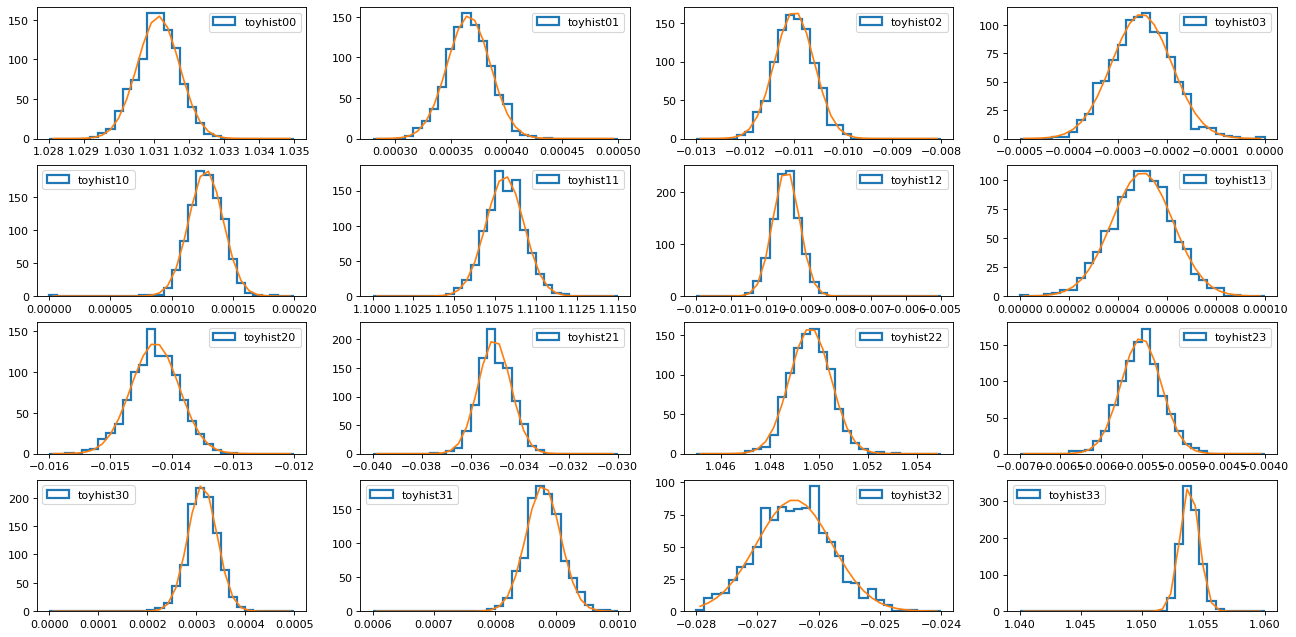

Errors for the inverse matrix:
[[5.98783264e-04 1.93267631e-05 4.03308297e-04 6.12273918e-05]
 [1.39973744e-05 1.16026539e-03 3.76865667e-04 1.24491942e-05]
 [3.91038254e-04 6.66789694e-04 8.41038938e-04 2.45521322e-04]
 [2.95715706e-05 2.81468126e-05 6.14836832e-04 7.73352552e-04]]


In [9]:
'''Number of toy experiments to be done'''
ntoy = 1000

'''Create numpy matrix of list to append elements of inverted toy matrices'''
inverse_toys = np.empty((4, 4))

'''Create toy efficiency matrix out of gaussian-distributed random values'''
for i in range(0, ntoy, 1):
    toy_matrix = np.zeros((4, 4))
    toy_matrix = np.random.normal(eff_matrix_final, error_eff_final, size=(4, 4))

    '''Invert toy matrix'''
    inverse_toy = np.linalg.inv(toy_matrix)
    inverse_toys = np.dstack((inverse_toys, inverse_toy))


'''Create numpy matrix to append elements for the inverse errors and means'''
inverse_errors = np.zeros((4, 4))
inverse_means = np.zeros((4, 4))

'''plot all 16 plots for the error matrix'''
fig = plt.figure(figsize=(20, 10), dpi=80)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.2)
ax00 = plt.subplot(4, 4, 1)
ax01 = plt.subplot(4, 4, 2)
ax02 = plt.subplot(4, 4, 3)
ax03 = plt.subplot(4, 4, 4)

ax10 = plt.subplot(4, 4, 5)
ax11 = plt.subplot(4, 4, 6)
ax12 = plt.subplot(4, 4, 7)
ax13 = plt.subplot(4, 4, 8)

ax20 = plt.subplot(4, 4, 9)
ax21 = plt.subplot(4, 4, 10)
ax22 = plt.subplot(4, 4, 11)
ax23 = plt.subplot(4, 4, 12)

ax30 = plt.subplot(4, 4, 13)
ax31 = plt.subplot(4, 4, 14)
ax32 = plt.subplot(4, 4, 15)
ax33 = plt.subplot(4, 4, 16)

axes = [[ax00, ax01, ax02, ax03],
        [ax10, ax11, ax12, ax13],
        [ax20, ax21, ax22, ax23],
        [ax30, ax31, ax32, ax33]]

'''Adapted ranges to fit/plot gaussian distributions successfully'''
ranges = [[(1.028, 1.035), (0.00028, 0.0005), (-0.013, -0.008), (-0.0005, 0)],
          [(0, 0.0002), (1.1, 1.115), (-0.012, -0.005), (0, 0.0001)],
          [(-0.016, -0.012), (-0.04, -0.03), (1.045, 1.055), (-0.007, -0.004)],
          [(0, 0.0005), (0.0006, 0.001), (-0.028, -0.024), (1.04, 1.06)]]

'''Fill histograms for each inverted matrix coefficient:'''
for j in range(0, 4, 1):
    for k in range(0, 4, 1):
        '''Diagonal and off-diagonal terms have different histogram ranges'''
        hbins, hedges, _ = axes[j][k].hist(inverse_toys[j, k, :], bins=30, range=ranges[j][k], histtype='step',
                                           linewidth=2, label=f'toyhist{j}{k}')
        axes[j][k].legend()

        '''Guess initial parameters of the fit by taking random value from hist and std'''
        _p0 = [ntoy / 10., np.mean(inverse_toys[j, k, :]), np.std(inverse_toys[j, k, :])]

        '''Get the fitted curve'''
        h_mid = 0.5 * (hedges[1:] + hedges[:-1])  # Calculate midpoints for the fit
        coeffs, _ = curve_fit(gauss, h_mid, hbins, p0=_p0, maxfev=100000)
        h_fit = gauss(h_mid, *coeffs)

        axes[j][k].plot(h_mid, h_fit, label=f'Fit{j}{k}')

        inverse_means[j, k] = coeffs[1]
        inverse_errors[j, k] = abs(coeffs[2])
plt.show()

print(f"Errors for the inverse matrix:\n{inverse_errors}")
inv_eff_matrix = np.linalg.inv(eff_matrix_final)

The width of the gaussian peaks determines the uncertainty of the elements of the inverse matrix.

# Exercise 2: Separate $t$- and $s$-channel contributions
Only Feynman diagrams contributing to the production of $Z$ boson are to be considered for the measurements. The electron (only electron, since these are the beam particles) MC sample incorporate contributions from $t$- and $s$-channels.  The aim of this part is to separate the $t$-channel contribution from the $s$-channel contribution. Here, the polar angle $\theta$ may be used for separation. The relative size of the $t$-channel amplitude depends on $\cos(\theta)$ (here referred to as ```cos_theta```). For $\cos{\theta} = 1$ this channel becomes a major component. Therefore, the angle is plotted and fits for both the $s$- as well the $t$-channel as well as their combination are fitted. A cut is defined visually. Detailed information about functions used here, may be found in the documetnation at the beginning of this document.

[-8.5578871e-01 -3.6037236e-01  9.9900000e+02 ...  7.3445606e-01
 -8.6465836e-01  8.7902808e-01]
S= 23.776403585063825 $\pm$ 0.15201159312641754 
 T= 1.3055122823879337 $\pm$ 0.012262126466743517


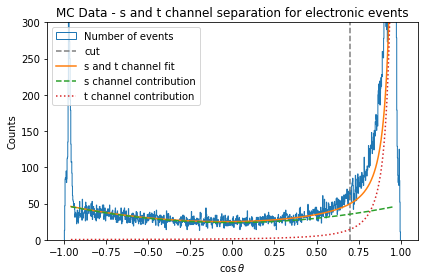

chi squared for the s and t channel fit: 3.7867148172492606


In [10]:
'''extract cos(theta) values as an array from detector data'''
cos_thet = ak.to_numpy(branches_ee['cos_thet'])

'''plot cos(theta) values (This corresponds to the differential crosssection), xlim to one, 
large number of values with number 999 correspond to detection errors. 
These will be omitted in the channel separation.
We believe, that the amount of detection errors is unphysical,
and may result from not optimised experimental conditions.'''
print(cos_thet)
bin_content, bin_edges = plot_hist_of_arrays([cos_thet], [1000],
                                             ['Number of events'], yrange=(0, 300), xrange=(-1, 1),
                                             xlabel=r'$\cos{\theta}$', verbose=False)


'''Calculate midpoint of the bars'''
bin_mid = 0.5 * (bin_edges[1:] + bin_edges[:-1])

'''def start and end position (relative to cos(theta) array position) for fit to work'''
start_fit = 20 # position 20 in the array corresponds to cos_theta = -0.96
end_fit = -20  # position -20 in the array corresponds to cos_theta = 0.96

'''fit cos(theta) with s and t channel fit, definition of the fits are at the top of this document'''
coeffs_st, covariance_st = curve_fit(s_and_t_channel, bin_mid[start_fit:end_fit], bin_content[start_fit:end_fit],
                                     sigma=np.sqrt(bin_content[start_fit:end_fit]), absolute_sigma=True)

'''determine the (uncorrelated) uncertainties of the fit parameters'''
errors_st_fit = np.sqrt(np.diag(covariance_st))

'''Calculate chi squared/dof for the fit'''
chi_sqrd_fit = np.sum((bin_content[start_fit:end_fit] - s_and_t_channel(bin_mid[start_fit:end_fit], *coeffs_st)) ** 2
                      / np.sqrt(bin_content[start_fit:end_fit]) ** 2) / len(
    bin_content[start_fit:end_fit])

'''Print results for fit parameters'''
print('S=', coeffs_st[0], r'$\pm$', np.sqrt(covariance_st[0][0]), '\n', 'T=', coeffs_st[1], r'$\pm$',
      np.sqrt(covariance_st[1][1]))

'''define cut for t channel'''
cut = 0.70

plt.errorbar(bin_mid[start_fit:end_fit], s_and_t_channel(bin_mid[start_fit:end_fit], *coeffs_st), fmt='-',
             label='s and t channel fit')
plt.errorbar(bin_mid[start_fit:end_fit], s_channel(bin_mid[start_fit:end_fit], coeffs_st[0]), fmt='--',
             label='s channel contribution')
plt.errorbar(bin_mid[start_fit:end_fit], t_channel(bin_mid[start_fit:end_fit], coeffs_st[1]), fmt=':',
             label='t channel contribution')
plt.axvline(cut, label='cut', color='C7', ls='--')
plt.title('MC Data - s and t channel separation for electronic events')
plt.legend()
plt.tight_layout()
plt.show()

print(f'chi squared for the s and t channel fit: {chi_sqrd_fit}')

Here we picture the distribution of the measured values of cos(theta). Around 40% of the data points had a default 
value of 999, which were cut off in this histogram. The fit was not performed over the whole range of [-1, 1]
in order to neglect disturbing values at the boundaries and get a decent fit. We obtained the contributions
S=23.78 $\pm$ 0.15 of the $s$-channel and T=1.306 $\pm$ 0.012 of the $t$-channel. Based on the fit of both those 
contributions a cut at cos(theta)<=0.7 is chosen to select only $s$-channel events. However, this also cuts
some $s$-channel events with a higher value. To quantify how many we evaluate the following integrals. The total number of events that we identify as $s$-channel contribute to the integral of $s$- and $t$-channel in the interval [-1, 0.7].
The actual number of $s$-channel events can be determined by the integral of only the s-channel contribution between 
[-1, 1]. The ratio of this determines how we have to correct the number of $s$-channel events we found. The coefficients were obtained by integrating the $s$- and $t$-channel contributions over the specific intervals.

In [11]:
chosen_as_s = integral_tands_range(*coeffs_st)
actual_s = integral_s_all(coeffs_st[0])

'''simple error propagation'''
error_chosen_as_s = integral_s_all(errors_st_fit[0])  

'''error propagation with covariance of fit parameters'''
error_actual_s = np.sqrt(
    (6443 / 3000 * errors_st_fit[0]) ** 2 + (17 / 6 * errors_st_fit[1]) ** 2 + 2 * 6443 / 3000 * 17 / 6 *
    covariance_st[0][1])

'''ratio between actual and chosen s-channel events'''
correction_schannel = actual_s / chosen_as_s  

'''gaußian error propagagtion'''
error_correction_schannel = correction_schannel * np.sqrt(
    (error_actual_s / actual_s) ** 2 + (error_chosen_as_s / chosen_as_s) ** 2)  

print('Correction factor:', correction_schannel, 'and error:', error_correction_schannel)

Correction factor: 1.1577898010934304 and error: 0.0103759145780652


This correction factor is going to be used to correct for the omitted s channel events later.

# Exercise 2b: Separate  𝑡 - and  𝑠 -channel contributions (with the detector data)

In addition to the sepatation of the $t$- and $s$-channels using the MC data, the separation was validated using the detector data. Steps are analogue to the previous separation.

importing dictionary from Data/cuts_final_dict.npy
S= 7.2272954783715635 $\pm$ 0.13549877280401035 
 T= 1.0138657814987015 $\pm$ 0.023990013348751747


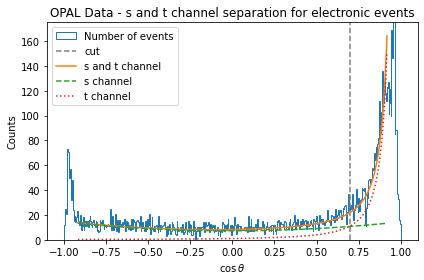

chi squared for the s and t channel fit: 1.5148328993446056
Correction factor: 1.0477506560023189 and error: 0.02592666056745377


In [12]:
'''read detector data (with uproot) and supplementary detector data (into a df)'''
detector_data = uproot.open(path_to_base_dir + 'daten_1.root')
detector_supplementary_data_df = pd.read_csv(path_to_base_dir + 'daten_1.csv')

dic_cuts = import_dictionary(path_to_base_dir + 'cuts_final_dict.npy')

ttree_name = 'myTTree'
branches_detector_data = detector_data[ttree_name].arrays()

dic_data = {}  # dictionary for data arrays of variables
variables = ['Pcharged', 'Ncharged', 'E_ecal', 'E_hcal', 'cos_thet']  # required arrays in the analysis
for var in variables:  # fill data dictionary with desired variable arrays
    dic_data[var] = ak.to_numpy(branches_detector_data[var])

'''extract cos(theta) values as an array from detector data'''
cos_thet_all_ee = ak.to_numpy(branches_detector_data['cos_thet'])

'''only select events that pass the electronic cuts'''
masks_variables = apply_cuts(dic_cuts, dic_data, cos_theta=False)
cos_thet_ee = cos_thet_all_ee[masks_variables['ee']]

# plot cos(theta) values, xlim to one, large number of values with number 999 correspond to wrong detections
bin_content, bin_edges = plot_hist_of_arrays([cos_thet_ee], [500],
                                             ['Number of events'], yrange=(0, 175), xrange=(-1, 1),
                                             xlabel=r'$\cos{\theta}$', verbose=False)


bin_mid = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Calculate midpoint of the bars

# def start and end position (relative to cos(theta) array position) for fit
start_fit = 20
end_fit = -20

# fit cos(theta) with s and t channel fit
coeffs_st_opal, covariance_st_opal = curve_fit(s_and_t_channel, bin_mid[start_fit:end_fit], bin_content[start_fit:end_fit],
                                     sigma=np.sqrt(bin_content[start_fit:end_fit]), absolute_sigma=True)

errors_st_fit_opal = np.sqrt(np.diag(covariance_st_opal))  # determine the (uncorrelated) uncertainties of the fit parameters

chi_sqrd_fit = np.sum((bin_content[start_fit:end_fit] - s_and_t_channel(bin_mid[start_fit:end_fit], *coeffs_st_opal)) ** 2
                      / np.sqrt(bin_content[start_fit:end_fit]) ** 2) / len(
    bin_content[start_fit:end_fit])  # Calculate chi squared/dof for the fit

print('S=', coeffs_st_opal[0], r'$\pm$', np.sqrt(covariance_st_opal[0][0]), '\n', 'T=', coeffs_st_opal[1], r'$\pm$',
      np.sqrt(covariance_st_opal[1][1]))  # Print results for fit parameters

# define cut for t channel
cut = 0.70

plt.errorbar(bin_mid[start_fit:end_fit], s_and_t_channel(bin_mid[start_fit:end_fit], *coeffs_st_opal), fmt='-',
             label='s and t channel')
plt.errorbar(bin_mid[start_fit:end_fit], s_channel(bin_mid[start_fit:end_fit], coeffs_st_opal[0]), fmt='--',
             label='s channel')
plt.errorbar(bin_mid[start_fit:end_fit], t_channel(bin_mid[start_fit:end_fit], coeffs_st_opal[1]), fmt=':',
             label='t channel')
plt.axvline(cut, label='cut', color='C7', ls='--')
plt.legend()
plt.title('OPAL Data - s and t channel separation for electronic events')
plt.tight_layout()
plt.show()

print(f'chi squared for the s and t channel fit: {chi_sqrd_fit}')

chosen_as_s_opal = integral_tands_range(*coeffs_st_opal)
actual_s_opal = integral_s_all(coeffs_st_opal[0])

error_chosen_as_s_opal = integral_s_all(errors_st_fit_opal[0])  # simple error propagation

error_actual_s_opal = np.sqrt(
    (6443 / 3000 * errors_st_fit_opal[0]) ** 2 + (17 / 6 * errors_st_fit_opal[1]) ** 2 + 2 * 6443 / 3000 * 17 / 6 *
    covariance_st[0][1])  # error propagation with covariance of fit parameters

correction_schannel_opal = actual_s_opal / chosen_as_s_opal  # ratio between actual and chosen s-channel events
'''gaußian error propagagtion'''
error_correction_schannel_opal = correction_schannel_opal * np.sqrt(
    (error_actual_s_opal / actual_s_opal) ** 2 + (error_chosen_as_s_opal / chosen_as_s_opal) ** 2)  

print('Correction factor:', correction_schannel_opal, 'and error:', error_correction_schannel_opal)

For the OPAL data much less events are considered compared to the MC data. A systematic error here may be due to the fact that the selection of electronic events may not be perfect.

# Exercise 3: Measurement of the total production cross sections

For **each** of the seven centre-of-mass energies:
* Determine the number of events in the handronic channel *and* in the three leptonic channels
* Substract the background and correct for selection efficiencies accordingly
* Then, calculate the differnetial cross sections for the hadronic *and* the leptnic channels
* Add the radiation corrections from The table given below. **Don't forget to take the uncertainties (errors) into account!**

| $\sqrt{s}$   \[GeV\]| Correction hadronic channel    \[nb\] |  Correction leptonic channel   \[nb\]|
| --- | --- | --- |
| 88.47 | +2.0  | +0.09 |
| 89.46 | +4.3  | +0.20 |
| 90.22 | +7.7  | +0.36 |
| 91.22 | +10.8 | +0.52 |
| 91.97 | +4.7  | +0.22 |
| 92.96 | -0.2  | -0.01 |
| 93.76 | -1.6  | -0.08 |

Feel free to access these values using the dictionary 'xs_corrections' given below.
* Once the total cross section for all four decay channels at all seven energies have been measured, fit a **Breit-Wigner distribution** to measure the $Z$ boson mass ($m_Z$) and the resonance width ($\Gamma_Z$) and the peak cross section s of the resonance for the hadronic and the leptonic channels. Again, **propagate the uncertainties carefully**.
* Compare your results to the OPAL cross section s and the theoretical predictions. How many degrees of freedom does the fit have? How can you udge if the model is compatible with the measured data? Calculate the  **confidence levels**.
* Calculate the partial widths for all channels from the measured cross sections on the peak. Which is the best partial width to start with? Compare them with the theoretical predictions and the values that you have calculated in the beginning.
* Determine from your results the **number of generations of light neutrinos**. Which assumptions are necessary?
* Discuss in detail the systematic uncertainties in the whole procedure of the analysis. Which assumptions were necessary?

These are some **references** that might be interesting to look up:
* Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf
** Resonances: https://pdg.lbl.gov/2017/reviews/rpp2017-rev-resonances.pdf
* Precision Electroweak Measurements on the Z Resonance (Combination LEP): https://arxiv.org/abs/hep-ex/0509008
* Measurement of the $Z^0$ mass and width with the OPAL detector at LEP: https://doi.org/10.1016/0370-2693(89)90705-3
* Measurement of the $Z^0$ line shape parameters and the electroweak couplings of charged leptons: https://inspirehep.net/literature/315269
* The OPAL Collaboration, *Precise Determination of the $Z$ Resonance Parameters at LEP: "Zedometry"*: https://arxiv.org/abs/hep-ex/0012018
* Fitting a Breit-Wigner curve using uproot: https://masonproffitt.github.io/uproot-tutorial/07-fitting/index.html

In [13]:
# Add cos_theta bounds to the cuts dictionary
dic_cuts['ee']['cos_thet'] = (-1, 0.7)  # add s-channel cut to ee events of the dictionary
dic_cuts['mm']['cos_thet'] = (-1, 1000)  # no cut applied to all other events (mm, tt, qq)
dic_cuts['tt']['cos_thet'] = (-1, 1000)
dic_cuts['qq']['cos_thet'] = (-1, 1000)

E_lep = ak.to_numpy(branches_detector_data['E_lep'])

# extract the luminosities from the detectos supp. data df into new array
luminosities = np.array(detector_supplementary_data_df['lumi'])

'''Identify which COM energy each event corresponds to'''
com_energies = np.array([88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76])
E_lep_edges = [44, 44.5, 45, 45.5, 45.7, 46, 46.5, 47]  # edges of the energy intervals for each COM energy: manually chosen

energies_datapoints = np.zeros(len(E_lep))

'''for each decay mode get one mask that includes the cuts of all variables'''
masks_variables = apply_cuts(dic_cuts, dic_data)
mask_cos = dic_data['cos_thet'] <= 0.7




'''Now determine the number of events that have passed the cuts for all seven COM energies'''
number_of_events = np.zeros((4, 7))

decay_modes = ['ee', 'mm', 'tt', 'qq']
for (i, com_energy) in zip(range(7), com_energies):  # identify which events are in the energy invervals and apply masks
    energy_mask = True
    energy_mask *= (E_lep >= E_lep_edges[i])
    energy_mask *= (E_lep <= E_lep_edges[i + 1])
    energies_datapoints += energy_mask * com_energy
    for (j, decay_mode) in zip(range(4), decay_modes):
        total_mask = masks_variables[decay_mode] * energy_mask
        number_of_events[j][i] = sum(total_mask) # Counts the number of events that passed the cuts for each decay mode

u_number_of_events = np.sqrt(number_of_events) # poisson distribution error
dic_data['com_energy'] = energies_datapoints

'''Apply the correction factor for electronic s_channel events. Do error propagation first, because the  uncorrected 
values of the electronic event numbers are needed.'''

s_channel_correction = correction_schannel
u_s_channel_correction = error_correction_schannel

'''The uncertainty of the number of events that pass the filter can be determined by a poisson distribution since the
numbers are sufficiently high.'''

u_number_of_events[0] = number_of_events[0]*np.sqrt((u_number_of_events[0]/number_of_events[0])**2+(u_s_channel_correction/s_channel_correction)**2)
number_of_events[0] *= s_channel_correction

In [14]:
#Change variable name
inv_eff_matrix_error = inverse_errors


branching_ratio = inv_eff_matrix @ number_of_events  # Correct the number of events for each decay mode with the inv efficiency matrix, i.e. the branching ratio


Determine the uncertainty of the branching ratio using the error propagation according to Eq. 11 of paper propagation
of errors. Here the uncertainties of the event fraction vector are uncorrelated since the cuts for each decay mode
can be chosen independently. The elements of the inverse efficiency matrix are also uncorrelated in our case because
of the method we used to get them. The widths of the Gauß Peaks in the Monte Carlo method were all measured independently.
We also only have to consider the diagonal elements of cov(B_i, B_j). Of course there is a correlation between the
branching ratios with the same luminosity. But in the further analysis we are only interested in the COM energy
(or luminosity dependence for each decay mode. These value do not have a correlation.

In [15]:
diag_cov_branch = np.zeros((4, 7)) # the diagonal element of the covariance of the branching ratios
for i in range(4):
    for j in range(7):
        for k in range(4):
            diag_cov_branch[i][j] += (number_of_events[k][j] ** 2 * inv_eff_matrix_error[i][k] ** 2) + \
                                ((inv_eff_matrix[i][k] ** 2) * (u_number_of_events[k][j] ** 2))

errors_branch = np.sqrt(diag_cov_branch)

'''Determine the crosssection by dividing the branching rations by all 7 luminosities'''

cross_sections = branching_ratio / luminosities[None, :]

'''The uncertainty of the cross section can easily be determined by a Gaussian error propagation because there is
no correlation between the values of the luminosities and the branching ratio.'''

'The uncertainty of the cross section can easily be determined by a Gaussian error propagation because there is\nno correlation between the values of the luminosities and the branching ratio.'

In [16]:
# extract the luminosities "errors all" from the detectors supp. data df into new array
# errors all includes both the statistical and the systematical errors
luminosities_error_all = np.array(detector_supplementary_data_df['all'])

relative_u_branch = errors_branch / branching_ratio # helper arrays for the error calculation
relative_u_lumi = luminosities_error_all/luminosities

relative_u_cross_sections = np.sqrt((relative_u_branch)**2 + (relative_u_lumi[None, :])**2)
u_cross_section = relative_u_cross_sections * cross_sections


'''Apply correction factors for leptonic and hadronic decays'''
# XS correction values need to be added to the data
xs_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                      'hadronic' : [2.0, 4.3, 7.7, 10.8, 4.7, -0.2, -1.6],
                      'leptonic' : [0.09, 0.20, 0.36, 0.52, 0.22, -0.01, -0.08]}
cross_sections_corrected = np.zeros((4,7))
cross_sections_corrected[0] = cross_sections[0] + xs_corrections['leptonic']
cross_sections_corrected[1] = cross_sections[1] + xs_corrections['leptonic']
cross_sections_corrected[2] = cross_sections[2] + xs_corrections['leptonic']
cross_sections_corrected[3] = cross_sections[3] + xs_corrections['hadronic']

'''Since we add a constand value with no error associated to it, the uncertanties do not change.'''

print('The crosssections for the 4 decay modes are:', '\n', 'ee:', cross_sections_corrected[0], 'with errors', u_cross_section[0])
print('mm:', cross_sections_corrected[1], 'with errors', u_cross_section[1])
print('tt:', cross_sections_corrected[2], 'with errors', u_cross_section[2])
print('qq:', cross_sections_corrected[3], 'with errors', u_cross_section[3])

The crosssections for the 4 decay modes are: 
 ee: [0.61470822 0.9781192  1.37983948 1.80855017 1.18939311 0.537403
 0.4435903 ] with errors [0.02711193 0.03705922 0.04846578 0.02377294 0.03880773 0.03290511
 0.02556538]
mm: [0.30654184 0.70095376 1.23793342 1.87292048 1.35696443 0.61551826
 0.3843075 ] with errors [0.01907107 0.03241431 0.04903795 0.02409023 0.04566939 0.03865845
 0.02631328]
tt: [0.43575526 0.69349527 1.04589311 1.78610352 1.24816635 0.60889158
 0.33922797] with errors [0.02472768 0.03355666 0.04598648 0.02500839 0.04558732 0.04025278
 0.02629981]
qq: [ 7.09781759 13.71264207 25.29863359 39.25752289 27.54805427 13.53454569
  7.96525655] with errors [0.09920293 0.15912244 0.26865171 0.22679162 0.27862755 0.2164382
 0.14064766]


info for plot: $e^{+}e^{-}$
fit parameters: [90.86931524  2.41411408  9.96014034  0.2060736 ]
errors of fit: [0.08450361 0.51355815 4.57882094 0.15201246]
chi squared test: 0.1587409415622889


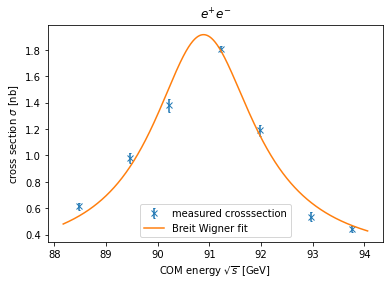

info for plot: $\mu^{+}\mu^{-}$
fit parameters: [ 9.11346124e+01  2.70324649e+00  1.41703056e+01 -6.31954273e-02]
errors of fit: [0.02382931 0.1211923  1.51016036 0.04313482]
chi squared test: 0.009659790514245247


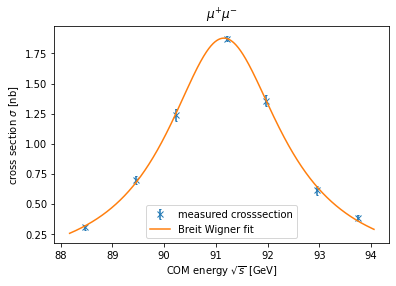

info for plot: $\tau^{+}\tau^{-}$
fit parameters: [91.12998185  2.230899    8.16080765  0.15212478]
errors of fit: [0.07194612 0.28995812 2.42520639 0.09132373]
chi squared test: 0.0708637440884605


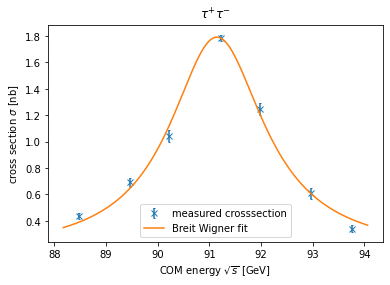

info for plot: $q\bar{q}$
fit parameters: [ 91.1457907    2.49313482 241.36158968   0.45757529]
errors of fit: [9.79314547e-03 4.87306168e-02 1.03255039e+01 3.12544727e-01]
chi squared test: 0.17079693551367564


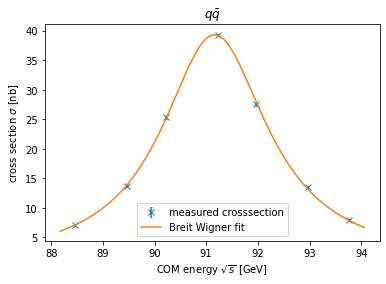

t test values: first column compares z mass with literature, the second the decay widths
[[3.76536017 0.15788884]
 [2.21504576 1.7163552 ]
 [0.80051042 0.91148572]
 [4.17434603 0.04233231]]


In [17]:
#plotting CME vs cross section:


coeffs_ee, u_coeffs_ee = plot_cme_cross_sec(com_energies, cross_sections_corrected[0], cross_section_data_error=u_cross_section[0])
coeffs_mm, u_coeffs_mm = plot_cme_cross_sec(com_energies, cross_sections_corrected[1], cross_section_data_error=u_cross_section[1], title=r'$\mu^{+}\mu^{-}$')
coeffs_tt, u_coeffs_tt = plot_cme_cross_sec(com_energies, cross_sections_corrected[2], cross_section_data_error=u_cross_section[2], title=r'$\tau^{+}\tau^{-}$')
coeffs_qq, u_coeffs_qq = plot_cme_cross_sec(com_energies, cross_sections_corrected[3], cross_section_data_error=u_cross_section[3], title=r'$q\bar{q}$')

'''
Next a t test is performed to check experiment data with literature values.
Literature is taken from P.A. Zyla et al. (Particle Data Group), Prog. Theor. Exp. Phys. 2020, 083C01 (2020) and 2021 update.
https://pdglive.lbl.gov/DataBlock.action?node=S044W#details-citation-1
'''

MZ_literature = 91.1876
u_MZ = 0.0021
width_literature = 2.4952
u_width = 0.0023
t_test_values = np.zeros((4, 2))

t_test_values[0][0] = t_test(coeffs_ee[0], MZ_literature, u_coeffs_ee[0], u_MZ)
t_test_values[1][0] = t_test(coeffs_mm[0], MZ_literature, u_coeffs_mm[0], u_MZ)
t_test_values[2][0] = t_test(coeffs_tt[0], MZ_literature, u_coeffs_tt[0], u_MZ)
t_test_values[3][0] = t_test(coeffs_qq[0], MZ_literature, u_coeffs_qq[0], u_MZ)
t_test_values[0][1] = t_test(coeffs_ee[1], width_literature, u_coeffs_ee[1], u_width)
t_test_values[1][1] = t_test(coeffs_mm[1], width_literature, u_coeffs_mm[1], u_width)
t_test_values[2][1] = t_test(coeffs_tt[1], width_literature, u_coeffs_tt[1], u_width)
t_test_values[3][1] = t_test(coeffs_qq[1], width_literature, u_coeffs_qq[1], u_width)

print('t test values: first column compares z mass with literature, the second the decay widths')
print(t_test_values)

The relative errorbars of the hadronic crosssections are considerably smaller due to the higher number of hadronic
events. This reduces the Poisson error. Therefore the cross section is in general significantly higher when compared to the other three decay types.

For all particles a gerneral form of the Breit-Wigner curve can be seen. For the electrons the fit shows the most fluctuation of the data points. This may be due to the fact that the s and t channel separation was performed on this data. The s and t channel contributions may be different for different COM energies. However, in our separation method above we only considered one COM energy, since this was the only data set in the MC data sample.

To check the compatibility with literature values a t test is implemented. For a value of t smaller than 2 the results are said to be compatible with the literature, otherwise not.

The fluctuation of the data points in the electron curve further translates to a larger t test value of about 12 for the z mass. For the tauon and muon events the Z mass is compatible with the literature. The decay width is compatible for all events except the tauon.

In the below results the energy is given in GeV.

In [18]:
'''Calculate the Decay widths of each mode from the fit parameters. For this the crosssections need to be transformed 
to natural units. From https://en.wikipedia.org/wiki/Barn_(unit) the conversion is 1nb=2.56819e6/GeV^2'''

unit_conversion = 2.56819e-6

gamma_dictionary = {}

gamma_dictionary['ee'] = get_gamma_ee(coeffs_ee[2]*unit_conversion, coeffs_ee[0])
gamma_dictionary['u_ee'] = get_gamma_ee_error(gamma_dictionary['ee'], coeffs_ee[2]*unit_conversion, u_coeffs_ee[2]*unit_conversion, coeffs_ee[0], u_coeffs_ee[0])
gamma_dictionary['mm'] = get_gamma_ff(coeffs_mm[2]*unit_conversion, coeffs_mm[0], gamma_dictionary['ee'])
gamma_dictionary['u_mm'] = get_gamma_ff_error(gamma_dictionary['mm'], coeffs_mm[2]*unit_conversion, u_coeffs_mm[2]*unit_conversion, coeffs_mm[0], u_coeffs_mm[0], gamma_dictionary['ee'], gamma_dictionary['u_ee'])

gamma_dictionary['tt'] = get_gamma_ff(coeffs_tt[2]*unit_conversion, coeffs_tt[0], gamma_dictionary['ee'])
gamma_dictionary['u_tt'] = get_gamma_ff_error(gamma_dictionary['tt'], coeffs_tt[2]*unit_conversion, u_coeffs_tt[2]*unit_conversion, coeffs_tt[0], u_coeffs_tt[0], gamma_dictionary['ee'], gamma_dictionary['u_ee'])

gamma_dictionary['qq'] = get_gamma_ff(coeffs_qq[2]*unit_conversion, coeffs_qq[0], gamma_dictionary['ee'])
gamma_dictionary['u_qq'] = get_gamma_ff_error(gamma_dictionary['qq'], coeffs_qq[2]*unit_conversion, u_coeffs_qq[2]*unit_conversion, coeffs_qq[0], u_coeffs_qq[0], gamma_dictionary['ee'], gamma_dictionary['u_ee'])


'''to calculate the invisible decay width, we used the Z decay width determined from the hydronic cross sections, 
because here the presion was the highest du to the large amount of data points.'''
gamma_inv = coeffs_qq[1]-gamma_dictionary['ee']-gamma_dictionary['mm']-gamma_dictionary['tt']-gamma_dictionary['qq'] # invisible/undetectable partof the decay width accounting for neutrinos
u_gamma_inv = np.sqrt(u_coeffs_qq[1]**2+gamma_dictionary['u_ee']**2+gamma_dictionary['u_mm']**2+gamma_dictionary['u_tt']**2+gamma_dictionary['u_qq']**2)

gamma_neutrino = 0.1676 # taken from instructions table 1, in GeV

neutrino_generations = gamma_inv / gamma_neutrino # number of light neutrino generations
u_neutrino_generations =u_gamma_inv / gamma_neutrino


print(gamma_dictionary)
print(f'neutrino generations:{neutrino_generations}')
print(f'error on the neutrino generations: {u_neutrino_generations}')
print(gamma_inv)
print(u_gamma_inv)

{'ee': 0.074851067807744, 'u_ee': 0.017205201422630035, 'mm': 0.10711343547617129, 'u_mm': 0.02713864762674181, 'tt': 0.06168133162419433, 'u_tt': 0.023173802882896197, 'qq': 1.824901477631919, 'u_qq': 0.42667357322068655}
neutrino generations:2.5333383726738545
error on the neutrino generations: 2.5732152014845107
0.42458751126013805
0.43127086776880397


With a value of 2.5 the number of neutrino generations is compatible with the expected value of 3,
however due to the large error of about 0.9 the value os also compatible with 2. Therefore our Analysis cannot be used to verify that the number of neutrino generations is in fact 3.

The error on the neutrino generation is mainly influenced by the uncertainty of the hadronic decay width, as this is the absolute largest contributor.

# Exercise 3: Forward-backward asymmetry and $\sin^2(\theta_\text{W})$ in muon final states

* Using the **muon channel only**, measure the forward-backward asymmetry $\mathcal{A}_\text{FB}$ using OPAL data and muon Monte Carlo events. Take into account the radiation corrections given below. 

| $\sqrt{s}$   \[GeV\]| Radiation correction [-]|  
| --- | --- | 
| 88.47 | 0.021512  | 
| 89.46 | 0.019262  | 
| 90.22 | 0.016713  | 
| 91.22 | 0.018293  | 
| 91.97 | 0.030286  | 
| 92.96 | 0.062196  | 
| 93.76 | 0.093850  | 

Feel free to use the dictionary 'radiation_corrections' given below.

* Measure the **Weinberg angle** as $\sin^2(\theta_\text{W})$. Compare the measurement with the literature.

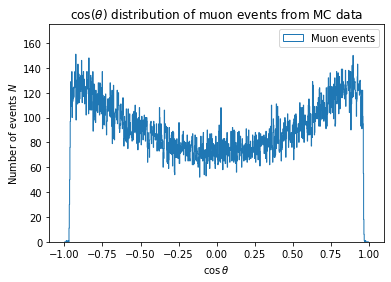

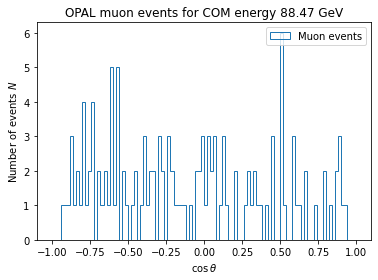

Number of forward Events: 53, Number of backward Events: 75


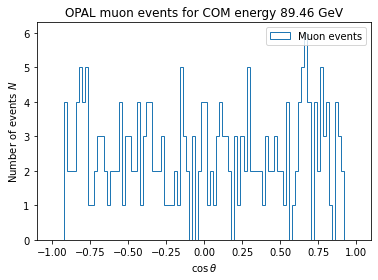

Number of forward Events: 115, Number of backward Events: 112


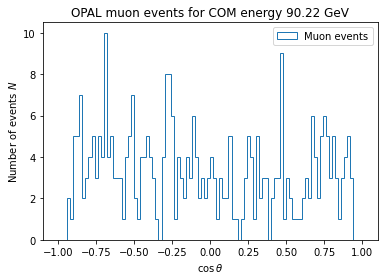

Number of forward Events: 137, Number of backward Events: 178


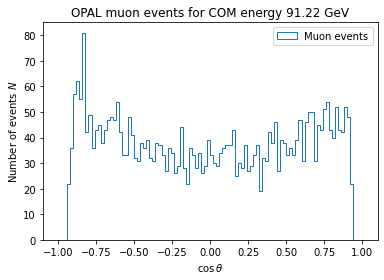

Number of forward Events: 1768, Number of backward Events: 1820


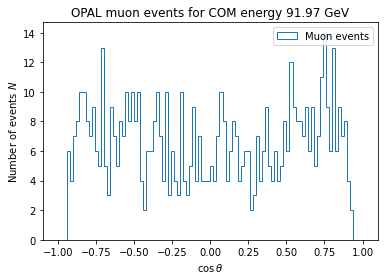

Number of forward Events: 318, Number of backward Events: 310


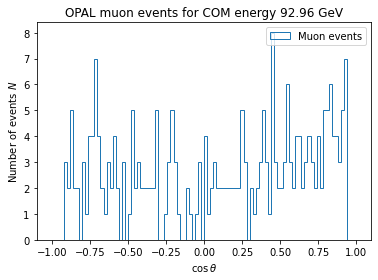

Number of forward Events: 147, Number of backward Events: 100


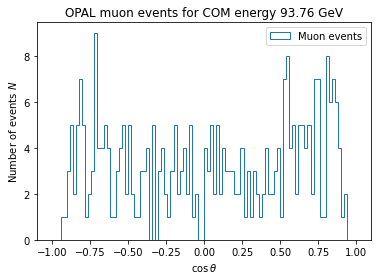

Number of forward Events: 168, Number of backward Events: 138
OPAL data:
Asymmetries:[-0.150363    0.03247786 -0.11344573  0.00380025  0.04302485  0.2524794
  0.19188922]
Asymmetries error: [0.08707302 0.06636653 0.05586431 0.01669276 0.03990111 0.06246593
 0.0568908 ]


In [19]:
# extract cos(theta) values as an array from Monte Carlo data for muon events
cos_thet_mc = ak.to_numpy(branches_mm['cos_thet'])

# masks_variables = apply_cuts(dic_cuts, dic_data, cos_theta=False)
cos_thet_all = dic_data['cos_thet']
cos_thet_opal = cos_thet_all[masks_variables['mm']]

# Create dictionary containing the cos(theta) arrays for muons for all 7 com_energies of detector data
dic_cos_thet = {}


for (i, com_energy) in zip(range(7), com_energies):  # identify which events are in the energy invervals and apply masks
    energy_mask = dic_data['com_energy'][masks_variables['mm']] == com_energy
    dic_cos_thet[com_energy] = cos_thet_opal[energy_mask]

bin_content_mc, bin_edges_mc = plot_hist_of_arrays([cos_thet_mc], [1000],
                                                   ['Muon events'], yrange=(0, 175), xrange=(-1, 1),
                                                   xlabel=r'$\cos{\theta}$', ylabel = r'Number of events $N$',title=r'$\cos(\theta)$ distribution of muon events from MC data', verbose=True)

# calculate the asymmetry for the MC data (only one energy)
'''only consider values |cos(theta)|<0.95 according to https://arxiv.org/abs/hep-ex/0012018 (Zedometry", p.26).'''
forward_mask_mc = cos_thet_mc < 0.95
forward_mask_mc *= cos_thet_mc > 0
A_forward_mc = sum(forward_mask_mc)

backward_mask_mc = cos_thet_mc > -0.95
backward_mask_mc *= cos_thet_mc < 0
A_backward_mc = sum(backward_mask_mc)

A_fb_mc = (A_forward_mc - A_backward_mc) / (A_forward_mc + A_backward_mc)

# simple Gauss error calculation
A_forward_error_mc = np.sqrt(A_forward_mc)
A_backward_error_mc = np.sqrt(A_backward_mc)
A_fb_mc_error = 2 / ((A_forward_mc + A_backward_mc) ** 2) * np.sqrt(
    A_forward_mc ** 2 * A_backward_mc + A_backward_mc ** 2 * A_forward_mc)

radiation_corrections = { 'energy' : [ 88.47, 89.46, 90.22, 91.22, 91.97, 92.96, 93.76] ,
                          'correction' : [0.021512, 0.019262, 0.016713, 0.018293, 0.030286, 0.062196, 0.093850]}
A_fb_mc_corrected = A_fb_mc + radiation_corrections['correction'][3]


# now analoguously calculate the asymmetry for the OPAL data (7 different energies)
asymmetries_opal = np.zeros(7)
u_asymmetries_opal = np.zeros(7)

for (i, com_energy_var) in zip(range(7), dic_cos_thet):
    bin_content_opal, bin_edges_opal = plot_hist_of_arrays([dic_cos_thet[com_energy_var]], [100],
                                                           ['Muon events'], xrange=(-1, 1),
                                                           xlabel=r'$\cos{\theta}$',ylabel = r'Number of events $N$',
                                                           title=r'OPAL muon events for COM energy {} GeV'.format(
                                                               com_energy_var), verbose=True)
    forward_mask = dic_cos_thet[com_energy_var] < 0.95
    forward_mask *= dic_cos_thet[com_energy_var] > 0
    A_forward = sum(forward_mask)

    backward_mask = dic_cos_thet[com_energy_var] > -0.95
    backward_mask *= dic_cos_thet[com_energy_var] < 0
    A_backward = sum(backward_mask)

    A_fb = (A_forward - A_backward) / (A_forward + A_backward)



    # simple Gauss error calculation
    A_forward_error = np.sqrt(A_forward)
    A_backward_error = np.sqrt(A_backward)
    error_A_fb = 2 / ((A_forward + A_backward) ** 2) * np.sqrt(
        A_forward ** 2 * A_backward + A_backward ** 2 * A_forward)
    u_asymmetries_opal[i] = error_A_fb
    asymmetries_opal[i] = A_fb + radiation_corrections['correction'][i]
    print(f'Number of forward Events: {A_forward}, Number of backward Events: {A_backward}')

print('OPAL data:')
print(f'Asymmetries:{asymmetries_opal}')
print(f'Asymmetries error: {u_asymmetries_opal}')

In [20]:
# Function to determine weinberg-angle out of the forward backward asymmetry
# Simplification only valid for Elep \approx 45.6 GeV
def sin2_w(A):
    return (1 - np.sqrt(A / 3)) * 1 / 4
def error_sin2_w(A, A_error):
    return 1/(8*np.sqrt(3)) * A_error/(np.sqrt(A))

weinberg_mc = sin2_w(A_fb_mc)
weinberg_mc_error = error_sin2_w(A_fb_mc, A_fb_mc_error)

'''We only calculate the Weinberg angle at the resonance energy 
because the simplified formula is only valid at the resonance energy.'''
weinberg_opal = sin2_w(asymmetries_opal[3])
weinberg_opal_error = error_sin2_w(asymmetries_opal[3], u_asymmetries_opal[3])

print(f'Weinberg MC: {weinberg_mc}')
print(f'Weinberg MC error: {weinberg_mc_error}')
print(f'Weinberg Opal:{weinberg_opal}')
print(f'Weinberg Opal error:{weinberg_opal_error}')

winberg_lit = 0.23121 #Particle Data Book: https://pdg.lbl.gov/2020/download/Prog.Theor.Exp.Phys.2020.083C01.pdf 

print(f't test MC: {t_test(weinberg_mc, winberg_lit, weinberg_mc_error, 0)}')

print(f't test OPAL: {t_test(weinberg_opal, winberg_lit, weinberg_opal_error, 0)}')

Weinberg MC: 0.2395146982088507
Weinberg MC error: 0.0033467006020183373
Weinberg Opal:0.24110214635336655
Weinberg Opal error:0.019542120067325152
t test MC: 2.4814583664407546
t test OPAL: 0.5061961711056331


The Weinberg angle calculated with the MC data is not compatible with the literature value. The angle calulated through the OPAL data does. Due to the smaller data points the uncertainty on this data is significantly larger when compared to the MC data because of the fewer data points.

# Exercise 4: Tests on lepton universlity

* Test the lepton universality from the total cross sectinos on the peak for $Z\to e^+ e^-$, $Z\to \mu^+ \mu^-$ and $Z\to \tau^+ \tau^-$ events. What is the ratio of the total cross section of the hadronic channel to the leptonic channels on the peak? Compare with the ratios obtained from the branching rations and discuss possible differences.

In [21]:
ratio_ee = coeffs_qq[2]/coeffs_ee[2]
ratio_mm = coeffs_qq[2]/coeffs_mm[2]
ratio_tt = coeffs_qq[2]/coeffs_tt[2]

#the coresponding error is calculated via gaussian error propagation
ratio_ee_error = np.sqrt((u_coeffs_qq[2]/coeffs_qq[2])**2 + (u_coeffs_ee[2]/coeffs_ee[2])**2) * ratio_ee
ratio_mm_error = np.sqrt((u_coeffs_qq[2]/coeffs_qq[2])**2 + (u_coeffs_mm[2]/coeffs_mm[2])**2) * ratio_mm
ratio_tt_error = np.sqrt((u_coeffs_qq[2]/coeffs_qq[2])**2 + (u_coeffs_tt[2]/coeffs_tt[2])**2) * ratio_tt


print(f'ratio ee: {ratio_ee} +- {ratio_ee_error}')
print(f'ratio mm: {ratio_mm} +- {ratio_mm_error}')
print(f'ratio tt: {ratio_tt} +- {ratio_tt_error}')

#literature values from PDG 
lit_ratio_ee = 20.804
lit_ratio_mm = 20.786
lit_ratio_tt = 20.764

lit_ratio_ee_error = 0.050
lit_ratio_mm_error = 0.033
lit_ratio_tt_error = 0.045

print(f't test ratio ee: {t_test(ratio_ee, lit_ratio_ee, ratio_ee_error, lit_ratio_ee_error)}')
print(f't test ratio mm: {t_test(ratio_mm, lit_ratio_mm, ratio_mm_error, lit_ratio_mm_error)}')
print(f't test ratio tt: {t_test(ratio_tt, lit_ratio_tt, ratio_tt_error, lit_ratio_tt_error)}')

ratio ee: 24.232749873661817 +- 11.18827845308322
ratio mm: 17.03291355250242 +- 1.956026560970953
ratio tt: 29.575698866752287 +- 8.879827974485158
t test ratio ee: 0.30645605127665637
t test ratio mm: 1.9184567933185712
t test ratio tt: 0.99231491269775
